# Language Detection Model Training

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import unicodedata
import json
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Wikipedia Dataset

In [6]:
"""
I decided to use the Wikipedia Language Identification Benchmark dataset to train my model. 
The dataset can be found at
https://www.kaggle.com/datasets/mexwell/wili-2018?resource=download
It is composed of 235 languages, with 1000 samples per language, equaling 235,000 total samples.
"""

# Read the text file of data by each line into a list
with open('wiki_languages/x_train.txt', 'r', encoding='utf-8') as file:
    data = [line.strip() for line in file.readlines()]

# Convert the list to a DataFrame
data = pd.DataFrame(data, columns=['text'])

# Read the text file of labels by each line into a list
with open('wiki_languages/y_train.txt', 'r', encoding='utf-8') as file:
    labels = [line.strip() for line in file.readlines()]

# Convert the labels list to a series
labels = pd.Series(labels, name='label')

# Combine the data and labels into a single DataFrame
data['label'] = labels

# lets take a look at what the first few rows of the dataset look like
print(data.head())

# Try some preprocessing steps out
# Get rid of extra whitespace
data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# More thorough text normalization function
def normalize_text(text):
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove URL patterns, email addresses. Probably not common in the dataset, but won't hurt
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers (language-agnostic)
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation clusters
    text = re.sub(r'[^\w\s]{2,}', ' ', text)
    
    return text.strip()

# The extra preprocessing didn't have much effect
#data['text'] = data['text'].apply(normalize_text)


                                                text label
0  Klement Gottwaldi surnukeha palsameeriti ning ...   est
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....   swe
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...   mai
3  Après lo cort periòde d'establiment a Basilèa,...   oci
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...   tha


## N - Gram -> TF-IDF -> Naive Bayes

In [7]:
"""
First I decided to implement a pipeline that uses:
N - Grams -> TF-IDF -> Multinomial Naive Bayes
N-Grams were used for text categorization in the paper
"N-Gram-Based Text Categorization" by Cavnar and Trenkle (1994). 
Found here: https://dsacl3-2019.github.io/materials/CavnarTrenkle.pdf
"""    

# Split the data into training and testing sets (The actual test set will be used later to compare both models)
# 80 - 20 split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Make a copy of the test so I can look at the actual text later
X_test_copy = X_test.copy()
"""
TF-IDF is an excellent choice for language classification because it is able to capture the importance of words (or n-grams) in a sentence relative to a collection of documents (corpus).

Setting the n-gram range had the most impact on the accuracy of the model.
The other parameters had little effect on the accuracy.
Without setting the max features, there are over 1 million features, but the model performs similarly with 10,000 features.
"""
# Create the TF-IDF Vectorizer with N-Grams 
# Experimenting with different n-gram ranges
# 92 percent accuracy with (1,3)
# 92 percent accuracy with (1,4) as well, but takes longer to train
# 90 percent accuracy with (2,2)
# 91 percent accuracy with (3,3)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', max_features=10000)

# Fit and transform the training data, then transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f'Training data shape: {X_train_tfidf.shape}')
print(f'Testing data shape: {X_test_tfidf.shape}')


Training data shape: (94000, 10000)
Testing data shape: (23500, 10000)


[(' ', 22520.618746050455), ('a', 14703.707822661685), ('e', 11723.248816744837), ('i', 10203.286942424775), ('n', 9738.401140217398), ('o', 7082.061813470186), ('r', 7026.917202993776), ('s', 6800.151717350656), ('t', 6723.138997205867), ('l', 5659.852411781818), ('u', 5162.535088148394), ('d', 4971.675171340961), ('а', 4107.420609403408), ('m', 4036.598865746633), ('k', 3869.326476303116), ('a ', 3675.4808160780594), ('e ', 3311.1022013198017), ('g', 3275.1563718632424), ('h', 3246.55476560796), ('c', 3178.0178693559265)]


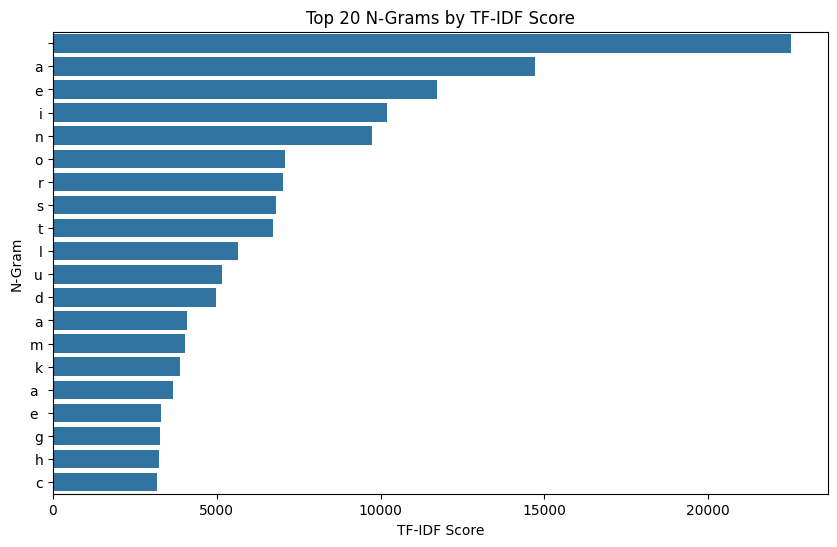

In [8]:
# Take a look at what the TF-IDF gave us:
# Lets take a look at some of the most distinctive (TF-IDF score) n-grams across the entire training set
sum_words = X_train_tfidf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
common_words = words_freq[:20]  
print(common_words)
df_common_words = pd.DataFrame(common_words, columns=['N-Gram', 'TF-IDF Score'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF Score', y='N-Gram', data=df_common_words)
plt.title('Top 20 N-Grams by TF-IDF Score')
plt.show()

In [9]:
"""
Multinomial Naive Bayes is a good choice for text classification tasks, especially when dealing with discrete features like word counts or frequencies.
It also works well with the TF-IDF representation of text data.
"""
# Now I will train a Multinomial Naive Bayes model on the TF-IDF transformed data
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)
y_pred = naive_bayes_model.predict(X_test_tfidf)

# Check the performance of the model using a confusion matrix
cm = confusion_matrix(y_test, y_pred)

#print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9220


In [10]:
# Load the labels csv to get the language names
labels_df = pd.read_csv('wiki_languages/labels.csv', sep=';')
# Create a mapping from label to language name
label_map = dict(zip(labels_df['Label'], labels_df['English']))

# Make a list of all the mistakes, with predicted and actual language names
mistakes = []
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label != pred_label:
        mistakes.append({
            'true_label': true_label,
            'predicted_label': pred_label,
            'true_language': label_map.get(true_label, true_label),
            'predicted_language': label_map.get(pred_label, pred_label),
            # The original text sample that was misclassified
            'text_sample': X_test_copy.iloc[i]  
        })

# Print out some of the mistakes
for mistake in mistakes[:10]:  # Print first 10 mistakes
    print(f"True: {mistake['true_language']} ({mistake['true_label']}) - Predicted: {mistake['predicted_language']} ({mistake['predicted_label']})")
    print(f"Text Sample: {mistake['text_sample']}")
    print("\n")

# What languages were most commonly confused?
confusion_counts = {}
for mistake in mistakes:
    pair = (mistake['true_language'], mistake['predicted_language'])
    if pair not in confusion_counts:
        confusion_counts[pair] = 0
    confusion_counts[pair] += 1

# Sort by most common confusions
sorted_confusions = sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)
print("Most common confusions:")
for (true_lang, pred_lang), count in sorted_confusions[:10]:  # Top 10 confusions
    print(f"{true_lang} -> {pred_lang}: {count}")

"""
The common confusions are languages that are very similar to each other as expected.
After looking at some of the mistakes I noticed that it is because some of the samples contain multiple languages in one sample. This may make the model more 
"""



True: Konkani (kok) - Predicted: Marathi (mar)
Text Sample: गांवांत २ शासकीय पूर्व-प्राथमिक शाळा आसा. ﻿गांवांत १ शासकीय प्राथमिक शाळा आसा. ﻿गांवांत १ शासकीय कनिष्ठ माध्यमिक शाळा आसा. ﻿गांवांत १ शासकीय माध्यमिक शाळा आसा. सगळ्यांत लागीं उच्च माध्यमिक शाळा (BALI) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं पदवी महाविद्यालय (CUNCOLIM) ५ ते १० किलोमिटराच्या अंतराचेर आसा. सगळ्यांत लागीं अभियांत्रिकी महाविद्यालय (BANDORA CT) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं वैजकी महाविद्यालय (BAMBOLIM CT) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं वैवस्थापन संस्था (MARGAO) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं पॉलिटेक्निक (CURCHOREM-CACORA) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं वेवसायिक प्रशिक्षण शाळा (CANACONA) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं अनौपचारिक प्रशिक्षणकेंद्र (MARGAO) १० किलोमिटर परस चड अंतराचेर आसा. सगळ्यांत लागीं अपंगांखातीर खाशेली शाळा (MARGAO) १० किलोमिटर परस चड अंतराचेर आसा.


True: Belarusian (bel) - Predicted: Belarusian (Taraschkewi

'\nThe common confusions are languages that are very similar to each other as expected.\nAfter looking at some of the mistakes I noticed that it is because some of the samples contain multiple languages in one sample. This may make the model more \n'

In [11]:
# Lets see it on the final test set now
with open('wiki_languages/x_test.txt', 'r', encoding='utf-8') as file:
    final_test_data = [line.strip() for line in file.readlines()]

final_test_data = pd.DataFrame(final_test_data, columns=['text'])

with open('wiki_languages/y_test.txt', 'r', encoding='utf-8') as file:
    final_test_labels = [line.strip() for line in file.readlines()]

final_test_labels = pd.Series(final_test_labels, name='label')

final_test_data['label'] = final_test_labels

# Transform the final test data using the same vectorizer
final_test_tfidf = vectorizer.transform(final_test_data['text'])
final_test_pred = naive_bayes_model.predict(final_test_tfidf)

# the accuracy
final_test_accuracy = accuracy_score(final_test_data['label'], final_test_pred)
print(f'Final Test Set Accuracy: {final_test_accuracy:.4f}')


Final Test Set Accuracy: 0.9235


## Word N-grams

In [12]:
# After exporting the above model and vectorizer to my command line script, I quickly found with some tests, that the model had overfit to the training data and struggled with short text and language with a more natural tone

# Tried using word n-grams instead of character n-grams

word_vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', max_features=10000)

X_train_word_tfidf = word_vectorizer.fit_transform(X_train)
X_test_word_tfidf = word_vectorizer.transform(X_test)

naive_bayes_model_word = MultinomialNB()
naive_bayes_model_word.fit(X_train_word_tfidf, y_train)
y_pred_word = naive_bayes_model_word.predict(X_test_word_tfidf)
accuracy_word = accuracy_score(y_test, y_pred_word)
print(f'Word N-Gram Model Accuracy: {accuracy_word:.4f}')
# Accuracy was worse, and after exporting the model, it sill was unable to generalize well.

Word N-Gram Model Accuracy: 0.8824


## Train on extra data for common languages

In [13]:
# In real world scenarios, many of the languges in the dataset are very unlikely to occur. Below I will add some extra data for the most common languages to help the model generalize better.

common_languages = common_languages = ['eng']

# Oversample these languages by multiplying their samples in the training set
common_lang_data = data[data['label'].isin(common_languages)]
common_lang_data = pd.concat([common_lang_data]*2, ignore_index=True) 

# Combine with the original training data
oversampled_train_data = pd.concat([data, common_lang_data], ignore_index=True)

over_X_train, over_y_train = oversampled_train_data['text'], oversampled_train_data['label']
over_vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', max_features=10000)
over_X_train_tfidf = over_vectorizer.fit_transform(over_X_train)
X_test_tfidf = over_vectorizer.transform(X_test)
naive_bayes_model_over = MultinomialNB()
naive_bayes_model_over.fit(over_X_train_tfidf, over_y_train)
y_pred_over = naive_bayes_model_over.predict(X_test_tfidf)
accuracy_over = accuracy_score(y_test, y_pred_over)
print(f'Oversampled Model Accuracy: {accuracy_over:.4f}')

# Accuracy dropped signigicantly, but it gets the short common phrases correct that the previous model missed.
# Below I will create an ensemble model that uses both models and picks the prediction from the model that is more confident in its prediction.

Oversampled Model Accuracy: 0.9172


## Ensemble Model

In [ ]:
def ensemble_predict(text):
    orig_features = vectorizer.transform([text])
    orig_proba = naive_bayes_model.predict_proba(orig_features)[0]
    orig_pred = naive_bayes_model.predict(orig_features)[0]
    orig_confidence = orig_proba.max()
    
    over_features = over_vectorizer.transform([text])
    over_proba = naive_bayes_model_over.predict_proba(over_features)[0]
    over_pred = naive_bayes_model_over.predict(over_features)[0]
    over_confidence = over_proba.max()
    
    if over_confidence > orig_confidence and over_confidence > .5:
        return over_pred, "overtrained", over_confidence
    else:
        return orig_pred, "original", orig_confidence

# Some random conversational phrases compiled into json using ai
with open('common_phrases.json', 'r', encoding='utf-8') as f:
    phrases_data = json.load(f)

test_phrases = []
for lang_code, phrases in phrases_data.items():
    test_phrases.extend(phrases)

print("Ensemble Results:")
for phrase in test_phrases:
    pred, model_used, conf = ensemble_predict(phrase)
    lang_name = label_map.get(pred, pred)
    print(f"'{phrase}' -> {lang_name} ({model_used} model, conf: {conf:.3f})")

print("Original results:")
for phrase in test_phrases:
    orig_features = vectorizer.transform([phrase])
    orig_pred = naive_bayes_model.predict(orig_features)[0]
    lang_name = label_map.get(orig_pred, orig_pred)
    print(f"'{phrase}' -> {lang_name} (original model)")

print("Oversampled Results:")
for phrase in test_phrases:
    over_features = over_vectorizer.transform([phrase])
    over_pred = naive_bayes_model_over.predict(over_features)[0]
    lang_name = label_map.get(over_pred, over_pred)
    print(f"'{phrase}' -> {lang_name} (Oversampled model)")

print("Word N-Gram Results:")
for phrase in test_phrases:
   word_features = word_vectorizer.transform([phrase])
   word_pred = naive_bayes_model_word.predict(word_features)[0]
   lang_name = label_map.get(word_pred, word_pred)
   print(f"'{phrase}' -> {lang_name} (Word N-gram model)")






Ensemble Results:
'Hello, how are you today?' -> Cornish (original model, conf: 0.114)
'What's the weather like?' -> English (enhanced model, conf: 0.956)
'Thank you very much' -> English (enhanced model, conf: 0.404)
'Nice to meet you' -> English (enhanced model, conf: 0.404)
'Have a great day' -> English (enhanced model, conf: 0.522)
'How was your weekend?' -> Cornish (original model, conf: 0.125)
'I'm doing well, thanks' -> English (enhanced model, conf: 0.538)
'See you later' -> Wolof (original model, conf: 0.092)
'Good morning everyone' -> English (enhanced model, conf: 0.653)
'Can you help me please?' -> English (enhanced model, conf: 0.432)
'I love this song' -> English (enhanced model, conf: 0.766)
'What time is it?' -> English (enhanced model, conf: 0.730)
'Where are you from?' -> English (enhanced model, conf: 0.606)
'How much does this cost?' -> English (enhanced model, conf: 0.811)
'I'm hungry, let's eat' -> Narom (original model, conf: 0.093)
'Excuse me' -> Galician (origi

In [16]:
# Test the ensemble on the entire wiki test set
ensemble_predictions = []
for text in X_test:
    pred, _, _ = ensemble_predict(text)
    ensemble_predictions.append(pred)

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"\nTest Set Accuracies:")
print(f"Original Model: {accuracy:.4f}")
print(f"Enhanced Model: {accuracy_over:.4f}") 
print(f"Ensemble Model: {ensemble_accuracy:.4f}")


Test Set Accuracies:
Original Model: 0.9220
Enhanced Model: 0.9172
Ensemble Model: 0.9174


## Export the Model

In [ ]:
# Export the model and vectorizer using joblib
joblib.dump(naive_bayes_model, 'language_detection_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

: 